In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from numpy import loadtxt
import xgboost
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import *
import time
from optparse import OptionParser
import matplotlib
from matplotlib import pyplot as plt
from tikzplotlib import save as tikz_save

In [2]:
df = pd.read_csv('../Dataset/compressive_strength.csv')
df.head()

,Cement (kg in a m^3 mixture),Blast Furnace Slag (kg in a m^3 mixture),Fly Ash (kg in a m^3 mixture),Water (kg in a m^3 mixture),Superplasticizer (kg in a m^3 mixture),Coarse Aggregate (kg in a m^3 mixture),Fine Aggregate (kg in a m^3 mixture),Age (day),"Concrete compressive strength (MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 9 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Cement (kg in a m^3 mixture)                       1133 non-null   float64
 1   Blast Furnace Slag (kg in a m^3 mixture)           1133 non-null   float64
 2   Fly Ash (kg in a m^3 mixture)                      1133 non-null   float64
 3   Water (kg in a m^3 mixture)                        1133 non-null   float64
 4   Superplasticizer (kg in a m^3 mixture)             1133 non-null   float64
 5   Coarse Aggregate (kg in a m^3 mixture)             1133 non-null   float64
 6   Fine Aggregate (kg in a m^3 mixture)               1133 non-null   float64
 7   Age (day)                                          1133 non-null   int64  
 8   Concrete compressive strength (MPa, megapascals)   1133 non-null   float64
dtypes: float6

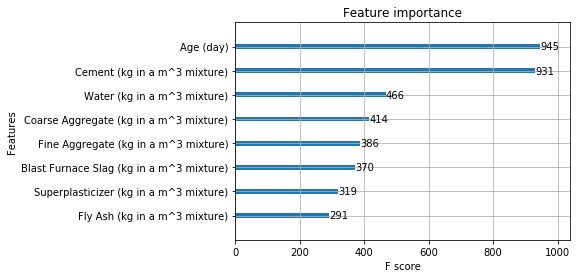

In [4]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
x_train=df.drop(['Concrete compressive strength (MPa, megapascals) '],axis=1)
y_train=df['Concrete compressive strength (MPa, megapascals) ']
classifier=xgboost.XGBRegressor()
regressor=XGBRegressor()
model = XGBRegressor()
model.fit(x_train, y_train)
#FEATURE IMPORTANCE
plot_importance(model)
pyplot.show()

In [5]:
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [6]:
# cross validation
# cross validation
def cv(random_state, poly_degree, model, problem, print_folds=True):
    interaction_only = False
    if problem.lower() == "compressive":
        data_file ='../Dataset/compressive_strength.csv'
        data = pd.read_csv(data_file)
        interaction_only = True

    elif problem.lower() == "tensile":
        data_file = '../Dataset/tensile_strength.csv'
        data = pd.read_csv(data_file)

    elif problem.lower() == "test2":
        data_file ='../Dataset/data2set.csv'
        data = pd.read_csv(data_file)
    else:
        print("The problem has to be compressive or tensile12 or tensile2")
        return

    data = data.values
    n_data_cols = np.shape(data)[1]
    n_features = n_data_cols - 1

    # retrieve data for features
    X = np.array(data[:, :n_features])
    y = np.array(data[:, n_features:])
    # split into 10 folds with shuffle
    n_folds = 10
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    start_time = time.time()
    scores = []
    fold_index = 0

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        X_scaler = MinMaxScaler(feature_range=(0, 1))
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

        y_scaler = MinMaxScaler(feature_range=(0, 1))
        y_train = y_scaler.fit_transform(y_train)

        if poly_degree >= 1:
            poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only)
            X_train = poly.fit_transform(X_train)
            X_test = poly.transform(X_test)
            # print ('Total number of features: ', X_train.size)

        model.fit(X_train, y_train.ravel())

        y_pred = model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

        # y_train_pred = model.predict(X_train)
        # y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

        # y_train = y_scaler.inverse_transform(y_train)

        # Error measurements
        r_lcc = r2_score(y_test, y_pred) ** 0.5
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        # print("RMSE on train: %s" % mean_squared_error(y_train, y_train_pred) ** 0.5)
        # print("RMSE on test: %s" % rmse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        scores.append([r_lcc, rmse, mae, mape])
        if print_folds:
            print("[fold {0}] r: {1:.5f}, rmse(MPa): {2:.5f}, mae(MPa): {3:.5f}, mape(%): {4:.5f}".
                  format(fold_index, scores[fold_index][0], scores[fold_index][1], scores[fold_index][2], scores[fold_index][3]))
        fold_index += 1
    scores = np.array(scores)
    # barplot(["R2", "RMSE", "MAE", "MAPE"], scores.mean(0), scores.std(0), "Metrics", "Values",
    #         "Performance with different metrics")
    print('k-fold mean:              ', scores.mean(0))
    print('k-fold standard deviation:', scores.std(0))

    # Running time
    print('Running time: %.3fs ' % (time.time() - start_time))
    return scores.mean(0)[1].item()


In [7]:
def run_model(regressor, params, random_state, poly_degree, problem):
    model = regressor(**params)
    cv(random_state=random_state, poly_degree=poly_degree, model=model, problem=problem)

In [8]:
# run cross validation for XGB
def run_xgb(random_state, poly_degree, n_estimators, max_depth, learning_rate,objective, problem):
    print("Running XGB for %s data with random_state=%s, poly_degree=%s, "
          "n_estimators=%s, max_depth=%s, learning_rate=%s, objective=%s" %
          (problem, random_state, poly_degree, n_estimators, max_depth, learning_rate, objective))

    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                         objective=objective, random_state=random_state)
    cv(random_state, poly_degree, model, problem=problem)
    print("Finished running XGB for %s data with random_state=%s, poly_degree=%s, "
          "n_estimators=%s, max_depth=%s, learning_rate=%s, objective=%s\n" %
          (problem, random_state, poly_degree, n_estimators, max_depth, learning_rate, objective))


In [9]:
if __name__ == "__main__":
   run_xgb(random_state=0, poly_degree=1, n_estimators=1000, max_depth=4,
          learning_rate=0.2,objective='reg:logistic',problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=1000, max_depth=4, learning_rate=0.2, objective=reg:logistic
[fold 0] r: 0.95887, rmse(MPa): 3.94719, mae(MPa): 2.50116, mape(%): 7.91651
[fold 1] r: 0.97067, rmse(MPa): 3.84039, mae(MPa): 2.34949, mape(%): 8.16057
[fold 2] r: 0.97863, rmse(MPa): 3.34907, mae(MPa): 2.36603, mape(%): 8.93340
[fold 3] r: 0.97642, rmse(MPa): 3.69418, mae(MPa): 2.47053, mape(%): 7.83135
[fold 4] r: 0.97889, rmse(MPa): 3.29443, mae(MPa): 2.25821, mape(%): 6.98731
[fold 5] r: 0.96932, rmse(MPa): 3.93971, mae(MPa): 2.64957, mape(%): 8.82717
[fold 6] r: 0.96602, rmse(MPa): 3.79462, mae(MPa): 2.61957, mape(%): 10.47297
[fold 7] r: 0.95947, rmse(MPa): 4.66432, mae(MPa): 2.74650, mape(%): 9.79539
[fold 8] r: 0.98155, rmse(MPa): 3.21610, mae(MPa): 2.17849, mape(%): 7.19807
[fold 9] r: 0.97001, rmse(MPa): 4.00790, mae(MPa): 2.53930, mape(%): 10.13503
k-fold mean:               [0.97098591 3.77479399 2.4678852  8.62577641]
k-fold stand

In [10]:
if __name__ == "__main__":
    run_xgb(random_state=97, poly_degree=1, n_estimators=139, max_depth=6,
        learning_rate=0.13, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=97, poly_degree=1, n_estimators=139, max_depth=6, learning_rate=0.13, objective=reg:logistic
[fold 0] r: 0.95705, rmse(MPa): 4.88583, mae(MPa): 3.14277, mape(%): 10.33520
[fold 1] r: 0.97275, rmse(MPa): 3.79856, mae(MPa): 2.71979, mape(%): 10.30733
[fold 2] r: 0.97107, rmse(MPa): 3.93885, mae(MPa): 2.74649, mape(%): 10.35990
[fold 3] r: 0.96746, rmse(MPa): 3.99172, mae(MPa): 2.82742, mape(%): 10.47890
[fold 4] r: 0.97494, rmse(MPa): 3.67904, mae(MPa): 2.58663, mape(%): 9.51603
[fold 5] r: 0.95497, rmse(MPa): 4.63286, mae(MPa): 3.08533, mape(%): 9.03725
[fold 6] r: 0.96523, rmse(MPa): 3.92960, mae(MPa): 2.93217, mape(%): 9.44433
[fold 7] r: 0.93485, rmse(MPa): 5.42022, mae(MPa): 3.28865, mape(%): 12.19555
[fold 8] r: 0.97609, rmse(MPa): 3.49714, mae(MPa): 2.45312, mape(%): 8.43959
[fold 9] r: 0.95507, rmse(MPa): 4.85649, mae(MPa): 2.93397, mape(%): 9.60309
k-fold mean:               [0.96295012 4.26303202 2.87163346 9.97171614]
k-fold s

In [11]:
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=139, max_depth=6,
        learning_rate=0.13, objective="reg:logistic", problem="compressive")
#parents=100

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=139, max_depth=6, learning_rate=0.13, objective=reg:logistic
[fold 0] r: 0.95629, rmse(MPa): 4.06684, mae(MPa): 2.84586, mape(%): 9.67342
[fold 1] r: 0.96227, rmse(MPa): 4.34649, mae(MPa): 2.76735, mape(%): 9.60605
[fold 2] r: 0.96565, rmse(MPa): 4.23251, mae(MPa): 2.87764, mape(%): 10.79944
[fold 3] r: 0.97371, rmse(MPa): 3.89798, mae(MPa): 2.67543, mape(%): 8.49100
[fold 4] r: 0.97578, rmse(MPa): 3.52586, mae(MPa): 2.61989, mape(%): 8.18944
[fold 5] r: 0.96216, rmse(MPa): 4.36747, mae(MPa): 2.95031, mape(%): 9.65866
[fold 6] r: 0.96280, rmse(MPa): 3.96703, mae(MPa): 2.85018, mape(%): 11.32656
[fold 7] r: 0.95567, rmse(MPa): 4.87335, mae(MPa): 3.05646, mape(%): 10.63571
[fold 8] r: 0.97412, rmse(MPa): 3.80189, mae(MPa): 2.42609, mape(%): 8.16284
[fold 9] r: 0.97092, rmse(MPa): 3.94740, mae(MPa): 2.72553, mape(%): 11.05610
k-fold mean:               [0.96593698 4.1026821  2.77947365 9.7599225 ]
k-fold sta

In [12]:
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=133, max_depth=6,
        learning_rate=0.13, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=133, max_depth=6, learning_rate=0.13, objective=reg:logistic
[fold 0] r: 0.95614, rmse(MPa): 4.07341, mae(MPa): 2.85480, mape(%): 9.71964
[fold 1] r: 0.96202, rmse(MPa): 4.36075, mae(MPa): 2.77877, mape(%): 9.65342
[fold 2] r: 0.96537, rmse(MPa): 4.24907, mae(MPa): 2.89788, mape(%): 10.92086
[fold 3] r: 0.97343, rmse(MPa): 3.91814, mae(MPa): 2.68409, mape(%): 8.50760
[fold 4] r: 0.97555, rmse(MPa): 3.54235, mae(MPa): 2.64465, mape(%): 8.27369
[fold 5] r: 0.96186, rmse(MPa): 4.38432, mae(MPa): 2.96606, mape(%): 9.69613
[fold 6] r: 0.96238, rmse(MPa): 3.98902, mae(MPa): 2.86344, mape(%): 11.37575
[fold 7] r: 0.95563, rmse(MPa): 4.87543, mae(MPa): 3.05768, mape(%): 10.63703
[fold 8] r: 0.97352, rmse(MPa): 3.84505, mae(MPa): 2.44284, mape(%): 8.22910
[fold 9] r: 0.97088, rmse(MPa): 3.95050, mae(MPa): 2.74027, mape(%): 11.11794
k-fold mean:               [0.96567882 4.11880185 2.79304736 9.813115  ]
k-fold sta

In [13]:
#parents=200
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=248, max_depth=8,
        learning_rate=0.2, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=248, max_depth=8, learning_rate=0.2, objective=reg:logistic
[fold 0] r: 0.96215, rmse(MPa): 3.78992, mae(MPa): 2.46379, mape(%): 8.55057
[fold 1] r: 0.96701, rmse(MPa): 4.06922, mae(MPa): 2.54739, mape(%): 8.82043
[fold 2] r: 0.96735, rmse(MPa): 4.12806, mae(MPa): 2.58415, mape(%): 9.41535
[fold 3] r: 0.97747, rmse(MPa): 3.61173, mae(MPa): 2.30703, mape(%): 7.44411
[fold 4] r: 0.97676, rmse(MPa): 3.45469, mae(MPa): 2.39119, mape(%): 7.23726
[fold 5] r: 0.96602, rmse(MPa): 4.14278, mae(MPa): 2.80313, mape(%): 9.31671
[fold 6] r: 0.96923, rmse(MPa): 3.61387, mae(MPa): 2.59069, mape(%): 10.46311
[fold 7] r: 0.95356, rmse(MPa): 4.98568, mae(MPa): 3.02276, mape(%): 10.18716
[fold 8] r: 0.97401, rmse(MPa): 3.80974, mae(MPa): 2.30170, mape(%): 7.58474
[fold 9] r: 0.96982, rmse(MPa): 4.02056, mae(MPa): 2.45349, mape(%): 9.71595
k-fold mean:               [0.9683378  3.9626251  2.54653389 8.87353875]
k-fold standa

In [14]:
#numberOfParents = 300 #number of parents to start
#numberOfParentsMating = 150 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=10, max_depth=9,
        learning_rate=0.6, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=10, max_depth=9, learning_rate=0.6, objective=reg:logistic
[fold 0] r: 0.94020, rmse(MPa): 4.73691, mae(MPa): 3.38328, mape(%): 11.47693
[fold 1] r: 0.95156, rmse(MPa): 4.91167, mae(MPa): 3.15638, mape(%): 11.37998
[fold 2] r: 0.94907, rmse(MPa): 5.13169, mae(MPa): 3.52585, mape(%): 13.34992
[fold 3] r: 0.96786, rmse(MPa): 4.30294, mae(MPa): 3.23549, mape(%): 10.45037
[fold 4] r: 0.96720, rmse(MPa): 4.09424, mae(MPa): 3.10975, mape(%): 10.35629
[fold 5] r: 0.94586, rmse(MPa): 5.20232, mae(MPa): 3.65007, mape(%): 11.59703
[fold 6] r: 0.94695, rmse(MPa): 4.71808, mae(MPa): 3.48837, mape(%): 14.17314
[fold 7] r: 0.93507, rmse(MPa): 5.86688, mae(MPa): 3.70971, mape(%): 12.48913
[fold 8] r: 0.96738, rmse(MPa): 4.26115, mae(MPa): 2.85992, mape(%): 9.70503
[fold 9] r: 0.95022, rmse(MPa): 5.13769, mae(MPa): 3.19377, mape(%): 12.86561
k-fold mean:               [ 0.95213844  4.83635738  3.33126081 11.78434235]
k-f

In [15]:
#numberOfParents = 400 #number of parents to start
#numberOfParentsMating = 200 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=55, max_depth=6,
        learning_rate=0.6, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=55, max_depth=6, learning_rate=0.6, objective=reg:logistic
[fold 0] r: 0.95002, rmse(MPa): 4.34146, mae(MPa): 3.03128, mape(%): 10.17700
[fold 1] r: 0.96089, rmse(MPa): 4.42380, mae(MPa): 2.95955, mape(%): 10.73368
[fold 2] r: 0.95827, rmse(MPa): 4.65615, mae(MPa): 3.00773, mape(%): 10.55813
[fold 3] r: 0.97797, rmse(MPa): 3.57197, mae(MPa): 2.38147, mape(%): 7.41704
[fold 4] r: 0.97406, rmse(MPa): 3.64737, mae(MPa): 2.62034, mape(%): 8.31110
[fold 5] r: 0.96764, rmse(MPa): 4.04454, mae(MPa): 2.81612, mape(%): 9.06493
[fold 6] r: 0.95568, rmse(MPa): 4.32214, mae(MPa): 3.14115, mape(%): 12.41850
[fold 7] r: 0.95083, rmse(MPa): 5.12628, mae(MPa): 3.14414, mape(%): 10.55911
[fold 8] r: 0.96558, rmse(MPa): 4.37533, mae(MPa): 2.58300, mape(%): 8.05793
[fold 9] r: 0.96954, rmse(MPa): 4.03867, mae(MPa): 2.92887, mape(%): 11.33664
k-fold mean:               [0.96304806 4.25477204 2.86136465 9.86340664]
k-fold sta

In [16]:
#numberOfParents = 250 #number of parents to start
#numberOfParentsMating = 125 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=10, max_depth=9,
        learning_rate=0.55, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=10, max_depth=9, learning_rate=0.55, objective=reg:logistic
[fold 0] r: 0.94520, rmse(MPa): 4.54047, mae(MPa): 3.20237, mape(%): 11.46111
[fold 1] r: 0.95743, rmse(MPa): 4.61149, mae(MPa): 2.98433, mape(%): 10.73262
[fold 2] r: 0.95024, rmse(MPa): 5.07385, mae(MPa): 3.48808, mape(%): 13.36014
[fold 3] r: 0.96531, rmse(MPa): 4.46766, mae(MPa): 3.12835, mape(%): 9.77210
[fold 4] r: 0.96357, rmse(MPa): 4.31074, mae(MPa): 3.30699, mape(%): 11.04105
[fold 5] r: 0.95507, rmse(MPa): 4.75076, mae(MPa): 3.50426, mape(%): 11.93204
[fold 6] r: 0.94939, rmse(MPa): 4.61131, mae(MPa): 3.43974, mape(%): 14.10868
[fold 7] r: 0.94385, rmse(MPa): 5.46821, mae(MPa): 3.56000, mape(%): 11.94295
[fold 8] r: 0.96537, rmse(MPa): 4.38836, mae(MPa): 2.78005, mape(%): 9.33664
[fold 9] r: 0.96561, rmse(MPa): 4.28736, mae(MPa): 2.96160, mape(%): 12.94712
k-fold mean:               [ 0.95610341  4.65102224  3.2355774  11.66344485]
k-f

In [17]:
#numberOfParents = 150 #number of parents to start
#numberOfParentsMating = 75 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=10, max_depth=6,
        learning_rate=0.17, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=10, max_depth=6, learning_rate=0.17, objective=reg:logistic
[fold 0] r: 0.88073, rmse(MPa): 6.58662, mae(MPa): 5.21269, mape(%): 24.46686
[fold 1] r: 0.89755, rmse(MPa): 7.04338, mae(MPa): 5.68509, mape(%): 22.50867
[fold 2] r: 0.90621, rmse(MPa): 6.88694, mae(MPa): 5.57422, mape(%): 27.69713
[fold 3] r: 0.91617, rmse(MPa): 6.85790, mae(MPa): 5.51913, mape(%): 19.67396
[fold 4] r: 0.91412, rmse(MPa): 6.53504, mae(MPa): 5.28111, mape(%): 20.92430
[fold 5] r: 0.90159, rmse(MPa): 6.93384, mae(MPa): 5.33467, mape(%): 21.52758
[fold 6] r: 0.89106, rmse(MPa): 6.66332, mae(MPa): 5.11879, mape(%): 25.24968
[fold 7] r: 0.89663, rmse(MPa): 7.32879, mae(MPa): 5.62860, mape(%): 23.24645
[fold 8] r: 0.91099, rmse(MPa): 6.93722, mae(MPa): 5.50988, mape(%): 22.92178
[fold 9] r: 0.88874, rmse(MPa): 7.55888, mae(MPa): 5.77585, mape(%): 28.40834
k-fold mean:               [ 0.90037941  6.93319237  5.46400344 23.66247494]
k

In [18]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=289, max_depth=6,
        learning_rate=0.56, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=289, max_depth=6, learning_rate=0.56, objective=reg:logistic
[fold 0] r: 0.95331, rmse(MPa): 4.19990, mae(MPa): 2.73083, mape(%): 9.15492
[fold 1] r: 0.96875, rmse(MPa): 3.96218, mae(MPa): 2.57547, mape(%): 9.39553
[fold 2] r: 0.97152, rmse(MPa): 3.85965, mae(MPa): 2.58085, mape(%): 9.35046
[fold 3] r: 0.97313, rmse(MPa): 3.93977, mae(MPa): 2.73563, mape(%): 8.61769
[fold 4] r: 0.97426, rmse(MPa): 3.63381, mae(MPa): 2.57907, mape(%): 7.85001
[fold 5] r: 0.97097, rmse(MPa): 3.83422, mae(MPa): 2.59503, mape(%): 8.73506
[fold 6] r: 0.96676, rmse(MPa): 3.75373, mae(MPa): 2.72354, mape(%): 10.99861
[fold 7] r: 0.95514, rmse(MPa): 4.90199, mae(MPa): 2.85475, mape(%): 9.93173
[fold 8] r: 0.97404, rmse(MPa): 3.80770, mae(MPa): 2.53281, mape(%): 8.18900
[fold 9] r: 0.97235, rmse(MPa): 3.85097, mae(MPa): 2.57099, mape(%): 9.69377
k-fold mean:               [0.96802166 3.97439282 2.64789849 9.19167775]
k-fold standa

In [19]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=289, max_depth=6,
        learning_rate=0.2, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=289, max_depth=6, learning_rate=0.2, objective=reg:logistic
[fold 0] r: 0.95732, rmse(MPa): 4.01936, mae(MPa): 2.56894, mape(%): 8.59951
[fold 1] r: 0.96103, rmse(MPa): 4.41623, mae(MPa): 2.79324, mape(%): 9.59691
[fold 2] r: 0.97098, rmse(MPa): 3.89528, mae(MPa): 2.54757, mape(%): 9.31701
[fold 3] r: 0.97953, rmse(MPa): 3.44448, mae(MPa): 2.33021, mape(%): 7.56031
[fold 4] r: 0.97411, rmse(MPa): 3.64406, mae(MPa): 2.47769, mape(%): 7.58186
[fold 5] r: 0.96984, rmse(MPa): 3.90659, mae(MPa): 2.65504, mape(%): 8.72338
[fold 6] r: 0.97084, rmse(MPa): 3.51927, mae(MPa): 2.43386, mape(%): 9.89969
[fold 7] r: 0.95803, rmse(MPa): 4.74475, mae(MPa): 2.88950, mape(%): 10.00883
[fold 8] r: 0.97964, rmse(MPa): 3.37658, mae(MPa): 2.22638, mape(%): 7.26880
[fold 9] r: 0.97074, rmse(MPa): 3.95945, mae(MPa): 2.61185, mape(%): 10.24359
k-fold mean:               [0.96920746 3.89260484 2.55342672 8.87998864]
k-fold standa

In [20]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=1400, max_depth=6,
        learning_rate=0.15, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=1400, max_depth=6, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.95797, rmse(MPa): 3.98950, mae(MPa): 2.51884, mape(%): 8.24857
[fold 1] r: 0.96768, rmse(MPa): 4.02842, mae(MPa): 2.50650, mape(%): 8.56882
[fold 2] r: 0.97406, rmse(MPa): 3.68576, mae(MPa): 2.43221, mape(%): 8.89371
[fold 3] r: 0.97735, rmse(MPa): 3.62143, mae(MPa): 2.38696, mape(%): 7.56328
[fold 4] r: 0.97898, rmse(MPa): 3.28751, mae(MPa): 2.24924, mape(%): 6.77720
[fold 5] r: 0.96706, rmse(MPa): 4.08004, mae(MPa): 2.69428, mape(%): 9.14487
[fold 6] r: 0.97542, rmse(MPa): 3.23507, mae(MPa): 2.27545, mape(%): 9.33539
[fold 7] r: 0.96100, rmse(MPa): 4.57731, mae(MPa): 2.73917, mape(%): 9.37310
[fold 8] r: 0.97695, rmse(MPa): 3.59074, mae(MPa): 2.30884, mape(%): 7.59437
[fold 9] r: 0.97620, rmse(MPa): 3.57576, mae(MPa): 2.26678, mape(%): 8.83553
k-fold mean:               [0.9712668  3.76715511 2.43782724 8.43348436]
k-fold standa

In [21]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=1000, max_depth=6,
        learning_rate=0.15, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=1000, max_depth=6, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.95780, rmse(MPa): 3.99711, mae(MPa): 2.51947, mape(%): 8.22528
[fold 1] r: 0.96735, rmse(MPa): 4.04847, mae(MPa): 2.51247, mape(%): 8.55930
[fold 2] r: 0.97409, rmse(MPa): 3.68395, mae(MPa): 2.42506, mape(%): 8.86827
[fold 3] r: 0.97704, rmse(MPa): 3.64554, mae(MPa): 2.41589, mape(%): 7.66531
[fold 4] r: 0.97912, rmse(MPa): 3.27656, mae(MPa): 2.25284, mape(%): 6.83452
[fold 5] r: 0.96731, rmse(MPa): 4.06452, mae(MPa): 2.68665, mape(%): 9.05329
[fold 6] r: 0.97479, rmse(MPa): 3.27539, mae(MPa): 2.31408, mape(%): 9.49409
[fold 7] r: 0.96093, rmse(MPa): 4.58123, mae(MPa): 2.75810, mape(%): 9.48175
[fold 8] r: 0.97690, rmse(MPa): 3.59420, mae(MPa): 2.31764, mape(%): 7.62411
[fold 9] r: 0.97575, rmse(MPa): 3.60952, mae(MPa): 2.29729, mape(%): 8.98734
k-fold mean:               [0.97110965 3.77764938 2.44994895 8.4793278 ]
k-fold standa

In [22]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=1100, max_depth=6,
        learning_rate=0.15, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=1100, max_depth=6, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.95781, rmse(MPa): 3.99662, mae(MPa): 2.52145, mape(%): 8.23459
[fold 1] r: 0.96750, rmse(MPa): 4.03975, mae(MPa): 2.50509, mape(%): 8.53790
[fold 2] r: 0.97416, rmse(MPa): 3.67890, mae(MPa): 2.42052, mape(%): 8.85325
[fold 3] r: 0.97710, rmse(MPa): 3.64101, mae(MPa): 2.41047, mape(%): 7.63825
[fold 4] r: 0.97915, rmse(MPa): 3.27453, mae(MPa): 2.25147, mape(%): 6.82110
[fold 5] r: 0.96716, rmse(MPa): 4.07370, mae(MPa): 2.69227, mape(%): 9.07779
[fold 6] r: 0.97504, rmse(MPa): 3.25968, mae(MPa): 2.29819, mape(%): 9.45053
[fold 7] r: 0.96106, rmse(MPa): 4.57382, mae(MPa): 2.74818, mape(%): 9.43912
[fold 8] r: 0.97702, rmse(MPa): 3.58524, mae(MPa): 2.30761, mape(%): 7.59897
[fold 9] r: 0.97577, rmse(MPa): 3.60752, mae(MPa): 2.29164, mape(%): 8.94794
k-fold mean:               [0.97117723 3.77307642 2.44468832 8.4599443 ]
k-fold standa

In [23]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=1, n_estimators=1300, max_depth=6,
        learning_rate=0.15, objective="reg:logistic", problem="compressive")

Running XGB for compressive data with random_state=0, poly_degree=1, n_estimators=1300, max_depth=6, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.95785, rmse(MPa): 3.99512, mae(MPa): 2.52137, mape(%): 8.24503
[fold 1] r: 0.96761, rmse(MPa): 4.03301, mae(MPa): 2.50534, mape(%): 8.55997
[fold 2] r: 0.97413, rmse(MPa): 3.68126, mae(MPa): 2.42724, mape(%): 8.87795
[fold 3] r: 0.97724, rmse(MPa): 3.62987, mae(MPa): 2.40023, mape(%): 7.60523
[fold 4] r: 0.97899, rmse(MPa): 3.28689, mae(MPa): 2.25507, mape(%): 6.80614
[fold 5] r: 0.96713, rmse(MPa): 4.07578, mae(MPa): 2.68855, mape(%): 9.11029
[fold 6] r: 0.97516, rmse(MPa): 3.25171, mae(MPa): 2.29142, mape(%): 9.40568
[fold 7] r: 0.96093, rmse(MPa): 4.58113, mae(MPa): 2.74764, mape(%): 9.41528
[fold 8] r: 0.97697, rmse(MPa): 3.58931, mae(MPa): 2.31111, mape(%): 7.60031
[fold 9] r: 0.97613, rmse(MPa): 3.58113, mae(MPa): 2.27332, mape(%): 8.88448
k-fold mean:               [0.971213   3.77052147 2.44212951 8.45103511]
k-fold standa

In [10]:
#numberOfParents = 210 #number of parents to start
#numberOfParentsMating = 105 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=2, n_estimators=700, max_depth=6,
        learning_rate=0.09, objective="reg:logistic", problem="tensile")

Running XGB for tensile data with random_state=0, poly_degree=2, n_estimators=700, max_depth=6, learning_rate=0.09, objective=reg:logistic
[fold 0] r: 0.97559, rmse(MPa): 0.30830, mae(MPa): 0.16830, mape(%): 7.30305
[fold 1] r: 0.98185, rmse(MPa): 0.23752, mae(MPa): 0.16210, mape(%): 5.93606
[fold 2] r: 0.97815, rmse(MPa): 0.28058, mae(MPa): 0.19357, mape(%): 7.64573
[fold 3] r: 0.97237, rmse(MPa): 0.31902, mae(MPa): 0.20625, mape(%): 7.20507
[fold 4] r: 0.98484, rmse(MPa): 0.24744, mae(MPa): 0.15893, mape(%): 6.30713
[fold 5] r: 0.97694, rmse(MPa): 0.26971, mae(MPa): 0.15959, mape(%): 6.47530
[fold 6] r: 0.97146, rmse(MPa): 0.32157, mae(MPa): 0.21007, mape(%): 7.17884
[fold 7] r: 0.98551, rmse(MPa): 0.23342, mae(MPa): 0.16260, mape(%): 5.58613
[fold 8] r: 0.98557, rmse(MPa): 0.23270, mae(MPa): 0.15914, mape(%): 6.06778
[fold 9] r: 0.97293, rmse(MPa): 0.28485, mae(MPa): 0.17789, mape(%): 6.59071
k-fold mean:               [0.97852023 0.27351038 0.17584387 6.62957982]
k-fold standard de

In [69]:
#numberOfParents = 250 #number of parents to start
#numberOfParentsMating = 125 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=2, n_estimators=700, max_depth=5,
        learning_rate=0.15, objective="reg:logistic", problem="tensile")

Running XGB for tensile data with random_state=0, poly_degree=2, n_estimators=700, max_depth=5, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.97497, rmse(MPa): 0.31210, mae(MPa): 0.16108, mape(%): 6.96969
[fold 1] r: 0.98296, rmse(MPa): 0.23025, mae(MPa): 0.15599, mape(%): 5.85299
[fold 2] r: 0.97824, rmse(MPa): 0.28005, mae(MPa): 0.19269, mape(%): 7.54741
[fold 3] r: 0.97357, rmse(MPa): 0.31208, mae(MPa): 0.20622, mape(%): 7.35011
[fold 4] r: 0.98674, rmse(MPa): 0.23155, mae(MPa): 0.15183, mape(%): 6.29184
[fold 5] r: 0.97753, rmse(MPa): 0.26628, mae(MPa): 0.15476, mape(%): 6.42746
[fold 6] r: 0.97004, rmse(MPa): 0.32936, mae(MPa): 0.21380, mape(%): 7.25072
[fold 7] r: 0.98636, rmse(MPa): 0.22652, mae(MPa): 0.16005, mape(%): 5.55139
[fold 8] r: 0.98542, rmse(MPa): 0.23384, mae(MPa): 0.16021, mape(%): 5.96341
[fold 9] r: 0.97222, rmse(MPa): 0.28851, mae(MPa): 0.17846, mape(%): 6.43306
k-fold mean:               [0.97880423 0.27105369 0.17351067 6.56381028]
k-fold standard de

In [10]:
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=2, n_estimators=100, max_depth=2,
        learning_rate=0.2, objective="reg:logistic", problem="test2")

Running XGB for test2 data with random_state=0, poly_degree=2, n_estimators=100, max_depth=2, learning_rate=0.2, objective=reg:logistic
[fold 0] r: 0.96748, rmse(MPa): 0.35510, mae(MPa): 0.25410, mape(%): 10.90921
[fold 1] r: 0.97095, rmse(MPa): 0.29969, mae(MPa): 0.23096, mape(%): 8.15388
[fold 2] r: 0.94897, rmse(MPa): 0.42566, mae(MPa): 0.29204, mape(%): 11.29526
[fold 3] r: 0.94443, rmse(MPa): 0.44920, mae(MPa): 0.33779, mape(%): 12.61138
[fold 4] r: 0.95806, rmse(MPa): 0.40881, mae(MPa): 0.29252, mape(%): 11.72618
[fold 5] r: 0.96515, rmse(MPa): 0.33059, mae(MPa): 0.24703, mape(%): 10.68393
[fold 6] r: 0.94750, rmse(MPa): 0.43344, mae(MPa): 0.31909, mape(%): 11.34759
[fold 7] r: 0.97344, rmse(MPa): 0.31505, mae(MPa): 0.23475, mape(%): 8.53774
[fold 8] r: 0.95218, rmse(MPa): 0.41999, mae(MPa): 0.29805, mape(%): 10.80038
[fold 9] r: 0.94672, rmse(MPa): 0.39693, mae(MPa): 0.27858, mape(%): 10.62472
k-fold mean:               [ 0.95748736  0.38344614  0.27849155 10.66902566]
k-fold st

In [66]:
#numberOfParents = 250 #number of parents to start
#numberOfParentsMating = 125 #number of parents that will mate
#numberOfParameters = 7 #number of parameters that will be optimized
#numberOfGenerations = 10 #number of genration that will be created
if __name__ == "__main__":
    run_xgb(random_state=0, poly_degree=2, n_estimators=50, max_depth=3,
        learning_rate=0.15, objective="reg:logistic", problem="test2")

Running XGB for test2 data with random_state=0, poly_degree=2, n_estimators=50, max_depth=3, learning_rate=0.15, objective=reg:logistic
[fold 0] r: 0.96651, rmse(MPa): 0.36027, mae(MPa): 0.25030, mape(%): 10.79046
[fold 1] r: 0.96969, rmse(MPa): 0.30600, mae(MPa): 0.23145, mape(%): 8.02406
[fold 2] r: 0.94980, rmse(MPa): 0.42225, mae(MPa): 0.29362, mape(%): 11.46427
[fold 3] r: 0.94785, rmse(MPa): 0.43553, mae(MPa): 0.32849, mape(%): 12.23622
[fold 4] r: 0.96051, rmse(MPa): 0.39694, mae(MPa): 0.29301, mape(%): 11.91023
[fold 5] r: 0.96148, rmse(MPa): 0.34723, mae(MPa): 0.26240, mape(%): 11.45122
[fold 6] r: 0.94640, rmse(MPa): 0.43785, mae(MPa): 0.31634, mape(%): 11.23984
[fold 7] r: 0.97194, rmse(MPa): 0.32370, mae(MPa): 0.23856, mape(%): 8.61507
[fold 8] r: 0.95092, rmse(MPa): 0.42533, mae(MPa): 0.30214, mape(%): 10.83771
[fold 9] r: 0.94700, rmse(MPa): 0.39594, mae(MPa): 0.26902, mape(%): 10.05898
k-fold mean:               [ 0.9572095   0.38510665  0.2785339  10.66280765]
k-fold st